<h1 style="text-align:center"> Minimize $ \mathbf{χ^2} $ </h1>

# DATA

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import scipy.optimize as opt
dataFromRatraNew = np.array([
        [0.070, 69.,19.6],
        [0.090,69.,12.],
        [0.120,68.6,26.2],
        [0.170,83.,8.],
        [0.179,75.,4.],
        [0.199,75.,5.],
        [0.200,72.9,29.6],
        [0.270,77.0,14.],
        [0.280,88.8,36.6],
        [0.352,83.,14.],
        [0.3802,83.,13.5],
        [0.400,95.,17.],
        [0.4004,77.,10.2],
        [0.4247,87.1,11.2],
        # [0.440,82.6,7.8], #The last paper of Yu ratra et al 2017, arXiv:1711.03437v1
        #discard this measurement.
        [0.4497,92.8,12.9],
        [0.47, 89.0, 50.0],
        #Here the [0.47, 89.0, 50.0] measurement is added to the list.
        [0.4783,80.9,9.],
        [0.480,97.,62.],
        [0.593,104.,13.],
        # [0.600,87.9,6.1], ###??? it is not in the list YuRattra
        [0.680,92.,8.],
        # [0.730,97.3,2.1], ###??? it is not in the list
        [0.781,105.,12.],
        [0.875,125.,17.],
        [0.880,90.,40.],
        [0.900,117.,23.],
        [1.037,154.,20.],
        [1.300,168.0,17.],
        [1.363,160.,33.6],
        [1.430,177.,18.],
        [1.530,140.,14.],
        [1.750,202.,40.],
        [1.965,186.5,50.4] ])

# lCDM model

In [2]:
def lCDM(z,fpars):
  
  Om_m0 = fpars[0]
  H_0 = fpars[1]
  E = (Om_m0*(1+z)**3 + 1-Om_m0)**0.5
  return E*H_0

 <h1 style="text-align:center"> $ \mathbf{χ^2} $ for lCDM </h1>

In [3]:
def chisq_lCDM(pars): 
  sum_chisq  = 0
  for dpoint in dataFromRatraNew:
    z = dpoint[0] 
    theorH = lCDM(z,pars)
    sigma = dpoint[2]
    H_obs = dpoint[1]
    x = (H_obs - theorH)**2 / sigma**2
    sum_chisq = sum_chisq + x
  return sum_chisq

In [4]:
x0 = np.array([0,0])
lcdm_opt= opt.minimize(chisq_lCDM, x0)

lcdm_best_pars=lcdm_opt.x

lcdm_chisq=lcdm_opt.fun

lcdm_chisq,lcdm_best_pars

(14.499985774271122, array([ 0.31955539, 68.14991651]))

# HDE model

In [5]:
def h_de(z,pars,O_de):
    H_0=pars[1]
    Om_0=pars[0]
    H = ((Om_0*(1/(1+z))**(-3) / (1-O_de)))**0.5
    return H*H_0
     

In [6]:
def o_de(om_de,z,C):
  dOdz = -om_de*(1-om_de)*(1 + 2*om_de**0.5/C)/(1+z)
  return dOdz

C=0.6

# create the values of z to solve the differential equation and calculate H(z)

In [7]:
#min_z=min(dataFromRatraNew[:,0])
max_z=max(dataFromRatraNew[:,0])

max_z

1.965

In [8]:
n_points=10000

zz = np.linspace(0,max_z,n_points)

h=zz[1]-zz[0]

In [9]:
def chisq_hde(pars,O_de):
    sum_chisq  = 0
    for dpoint in dataFromRatraNew:
        z = dpoint[0]  
        
        # take the value of O_de[i] that corresponds to the z of the data . i.e. O_de[0] is for z=0 is 0de_0
        # 0_de[1] is for z=h, And we solve backwards for i 
        
        theorH = h_de(z,pars,O_de[int((z/h))])  #  z_i= h*i,  i=z_i/h
        
        sigma = dpoint[2]
        H_obs = dpoint[1]
        x = (H_obs - theorH)**2 / sigma**2
        sum_chisq = sum_chisq + x
        
    return sum_chisq
    

In [10]:
sample_rate=150
Om_space = np.linspace(0.05,1, sample_rate)
H0_space  = np.linspace(50,80, sample_rate)

xx, yy = np.meshgrid(Om_space, H0_space)

Xgrid = np.vstack([xx.ravel(), yy.ravel()]).T



In [11]:
def chisq_hde_last(pars):
    Om_0=pars[0]
    H_0=pars[1]
    
    y0=1-Om_0 # initial condition
    
    O_de= odeint(o_de,y0,zz,args=(C,))
    
    return chisq_hde(pars,O_de)

In [12]:
hde_chisq_all=chisq_hde_last([Xgrid[:,0], Xgrid[:,1]])

hde_best_pars=Xgrid[np.argmin(hde_chisq_all)]

hde_chisq=min(hde_chisq_all)

hde_best_pars,hde_chisq

(array([ 0.29228188, 71.1409396 ]), 14.28264531901841)

# Plot

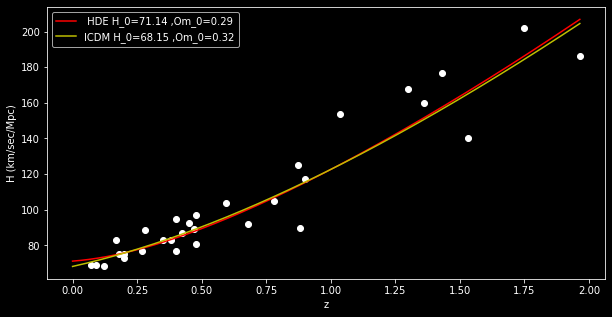

In [13]:
hologr = []

y0=1-hde_best_pars[0]
O_de = odeint(o_de,y0,zz,args=(C,))

for i,z in enumerate(zz):
  H_de = h_de(z,hde_best_pars,O_de[int(z/h)])  
  hologr.append(H_de) 
    
    
plt.style.use("dark_background")
plt.figure(figsize=(10,5))
plt.plot(zz,hologr,label=f" HDE H_0={round(hde_best_pars[1],2)} ,Om_0={round(hde_best_pars[0],2)}",c='red')

plt.xlabel('z')
plt.ylabel('H (km/sec/Mpc)')

plt.plot(zz,lCDM(zz,lcdm_best_pars),c='y',
         label=f"lCDM H_0={round(lcdm_best_pars[1],2)} ,Om_0={round(lcdm_best_pars[0],2)}")


plt.scatter(dataFromRatraNew[:,0],dataFromRatraNew[:,1],c='w')
plt.legend()
plt.show()  